# Frozen Smoke Topology

**Purpose:** Analyze the adjacency structure of the frozen smoke—which vectors connect to which, and how.

---

## Adjacency Metrics

Two vectors are **L∞-adjacent** if their bit patterns differ by at most 1 in every dimension:

$$L_\infty(u, v) = \max_i |u_i - v_i| \leq 1$$

The **L1 distance** tells us *how diagonal* the adjacency is:

$$L_1(u, v) = \sum_i |u_i - v_i|$$

| L1 | Interpretation |
|----|----------------|
| 1 | Face neighbor (orthogonal, moved in 1 dimension) |
| 2 | Edge neighbor (moved in 2 dimensions) |
| 3+ | Corner neighbor (moved in 3+ dimensions) |

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from safetensors.torch import load_file
from pathlib import Path

# Paths
DATA_DIR = Path("../../../tensors/Qwen3-4B-Instruct-2507")

# Load data
W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)
masks = load_file(DATA_DIR / "masks.safetensors")
neighborhood_mask = masks['neighborhood_mask']

# Extract unique vectors
neighborhood_indices = torch.where(neighborhood_mask)[0]
W_neighborhood = W[neighborhood_indices]

unique_bits, inverse_indices, counts = torch.unique(
    W_neighborhood.view(torch.uint16).to(torch.int32), dim=0,
    return_inverse=True, return_counts=True
)

n_unique = len(unique_bits)
print(f"Unique vectors: {n_unique}")

Unique vectors: 125


## Compute Pairwise Distances

In [2]:
# Compute pairwise L∞ and L1 distances in bit space
print("Computing pairwise distances...")

linf_matrix = torch.zeros(n_unique, n_unique, dtype=torch.int32)
l1_matrix = torch.zeros(n_unique, n_unique, dtype=torch.int32)

for i in range(n_unique):
    diff = torch.abs(unique_bits[i] - unique_bits)
    linf_matrix[i] = diff.max(dim=1).values
    l1_matrix[i] = diff.sum(dim=1)

print(f"L∞ range: [{linf_matrix.min().item()}, {linf_matrix.max().item()}]")
print(f"L1 range: [{l1_matrix.min().item()}, {l1_matrix.max().item()}]")

Computing pairwise distances...
L∞ range: [0, 33782]
L1 range: [0, 619925]


## Adjacency Graph (L∞ = 1)

In [3]:
# Build adjacency graph
G = nx.Graph()

for i in range(n_unique):
    G.add_node(i, count=counts[i].item())

edge_data = []  # (i, j, linf, l1)
for i in range(n_unique):
    for j in range(i+1, n_unique):
        linf = linf_matrix[i, j].item()
        l1 = l1_matrix[i, j].item()
        if linf == 1:
            G.add_edge(i, j, l1=l1)
            edge_data.append((i, j, linf, l1))

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges (L∞=1): {G.number_of_edges()}")
print(f"Connected components: {nx.number_connected_components(G)}")

Nodes: 125
Edges (L∞=1): 100
Connected components: 96


In [4]:
# L1 distribution for L∞=1 edges
l1_values = [e[3] for e in edge_data]

print("\nL1 distribution for L∞=1 adjacencies:")
for l1_val in sorted(set(l1_values)):
    count = l1_values.count(l1_val)
    pct = count / len(l1_values) * 100
    label = {1: 'face', 2: 'edge', 3: 'corner'}.get(l1_val, f'{l1_val}D-corner')
    print(f"  L1={l1_val} ({label}): {count} edges ({pct:.1f}%)")


L1 distribution for L∞=1 adjacencies:
  L1=1 (face): 24 edges (24.0%)
  L1=2 (edge): 37 edges (37.0%)
  L1=3 (corner): 24 edges (24.0%)
  L1=4 (4D-corner): 13 edges (13.0%)
  L1=7 (7D-corner): 2 edges (2.0%)


## Connected Components

In [5]:
# Analyze connected components
components = list(nx.connected_components(G))

# Sort by total token count
components_sorted = sorted(components, 
                           key=lambda c: sum(counts[i].item() for i in c), 
                           reverse=True)

print(f"Connected components: {len(components)}")
print()
print(f"{'Comp':>5} {'Vectors':>8} {'Tokens':>10} {'BHs':>5} {'BH Tokens':>10}")
print("-" * 45)

for i, comp in enumerate(components_sorted[:15]):
    n_vec = len(comp)
    n_tok = sum(counts[j].item() for j in comp)
    bh_nodes = [j for j in comp if counts[j].item() > 1]
    n_bh = len(bh_nodes)
    bh_tok = sum(counts[j].item() for j in bh_nodes)
    print(f"{i+1:>5} {n_vec:>8} {n_tok:>10,} {n_bh:>5} {bh_tok:>10,}")

if len(components_sorted) > 15:
    print(f"  ... and {len(components_sorted) - 15} more (all singletons or small)")

Connected components: 96

 Comp  Vectors     Tokens   BHs  BH Tokens
---------------------------------------------
    1       15      1,070     5      1,060
    2        8        712     2        706
    3        7        312     1        306
    4        1         10     1         10
    5        1          6     1          6
    6        2          6     1          5
    7        1          4     1          4
    8        1          3     1          3
    9        2          2     0          0
   10        1          1     0          0
   11        1          1     0          0
   12        1          1     0          0
   13        1          1     0          0
   14        1          1     0          0
   15        1          1     0          0
  ... and 81 more (all singletons or small)


## Black Hole Adjacency Matrix

In [6]:
# Focus on black holes
bh_mask = counts > 1
bh_indices = torch.where(bh_mask)[0].tolist()
n_bh = len(bh_indices)

print(f"Black holes: {n_bh}")
print(f"Populations: {[counts[i].item() for i in bh_indices]}")
print()

# L∞ distance matrix for black holes
print("L∞ distances between black holes:")
print()

# Header
header = "         " + " ".join(f"{counts[i].item():>5}" for i in bh_indices)
print(header)
print("-" * len(header))

for i, idx_i in enumerate(bh_indices):
    row = f"{counts[idx_i].item():>5}    "
    for j, idx_j in enumerate(bh_indices):
        if i == j:
            row += f"{'---':>5} "
        else:
            d = linf_matrix[idx_i, idx_j].item()
            row += f"{d:>5} "
    print(row)

Black holes: 13
Populations: [11, 6, 3, 228, 814, 4, 704, 2, 3, 10, 306, 5, 4]

L∞ distances between black holes:

            11     6     3   228   814     4   704     2     3    10   306     5     4
--------------------------------------------------------------------------------------
   11      ---     4     1     1     1     1     2     2     8     8     8    10     8 
    6        4   ---     5     4     4     4     4     4     8     8     8     8     4 
    3        1     5   ---     1     1     2     3     3     8     8     8    11     9 
  228        1     4     1   ---     1     1     2     2     8     8     8    10     8 
  814        1     4     1     1   ---     1     2     2     8     8     8    10     8 
    4        1     4     2     1     1   ---     2     2     8     8     8     9     7 
  704        2     4     3     2     2     2   ---     1     8     8     8     8     6 
    2        2     4     3     2     2     2     1   ---     8     8     8     8     6 
    3  

In [7]:
# Which black holes are adjacent?
print("\nBlack hole adjacencies (L∞=1):")

adjacent_pairs = []
for i, idx_i in enumerate(bh_indices):
    for j, idx_j in enumerate(bh_indices):
        if i < j:
            linf = linf_matrix[idx_i, idx_j].item()
            l1 = l1_matrix[idx_i, idx_j].item()
            if linf == 1:
                adjacent_pairs.append((idx_i, idx_j, l1))
                c_i, c_j = counts[idx_i].item(), counts[idx_j].item()
                adj_type = {1: 'face', 2: 'edge'}.get(l1, f'{l1}D')
                print(f"  BH({c_i}) <-> BH({c_j}): L1={l1} ({adj_type})")

print(f"\nTotal adjacent black hole pairs: {len(adjacent_pairs)}")
print(f"Total possible pairs: {n_bh * (n_bh - 1) // 2}")


Black hole adjacencies (L∞=1):
  BH(11) <-> BH(3): L1=4 (4D)
  BH(11) <-> BH(228): L1=1 (face)
  BH(11) <-> BH(814): L1=2 (edge)
  BH(11) <-> BH(4): L1=3 (3D)
  BH(3) <-> BH(228): L1=3 (3D)
  BH(3) <-> BH(814): L1=2 (edge)
  BH(228) <-> BH(814): L1=1 (face)
  BH(228) <-> BH(4): L1=2 (edge)
  BH(814) <-> BH(4): L1=1 (face)
  BH(704) <-> BH(2): L1=1 (face)

Total adjacent black hole pairs: 10
Total possible pairs: 78


## Main Component Deep Dive

In [8]:
# Get main component (containing biggest black hole)
biggest_bh = counts.argmax().item()
main_comp = None
for comp in components:
    if biggest_bh in comp:
        main_comp = comp
        break

main_nodes = list(main_comp)
print(f"Main component: {len(main_nodes)} vectors")

# Subgraph
G_main = G.subgraph(main_nodes)

print(f"Edges in main component: {G_main.number_of_edges()}")
print(f"Density: {nx.density(G_main):.1%}")
print()

# Node details
print(f"{'Node':>6} {'Tokens':>8} {'Degree':>8} {'Type':>10}")
print("-" * 35)
for node in sorted(main_nodes, key=lambda n: counts[n].item(), reverse=True):
    n_tok = counts[node].item()
    degree = G_main.degree(node)
    node_type = 'BH' if n_tok > 1 else 'single'
    print(f"{node:>6} {n_tok:>8} {degree:>8} {node_type:>10}")

Main component: 15 vectors
Edges in main component: 66
Density: 62.9%

  Node   Tokens   Degree       Type
-----------------------------------
    40      814       12         BH
    39      228       12         BH
    25       11       12         BH
    43        4        9         BH
    34        3        8         BH
    35        1        8     single
    36        1        8     single
    37        1       10     single
    38        1       10     single
    41        1       10     single
    42        1        9     single
    44        1        2     single
    45        1        9     single
    46        1       11     single
    47        1        2     single


## Visualization

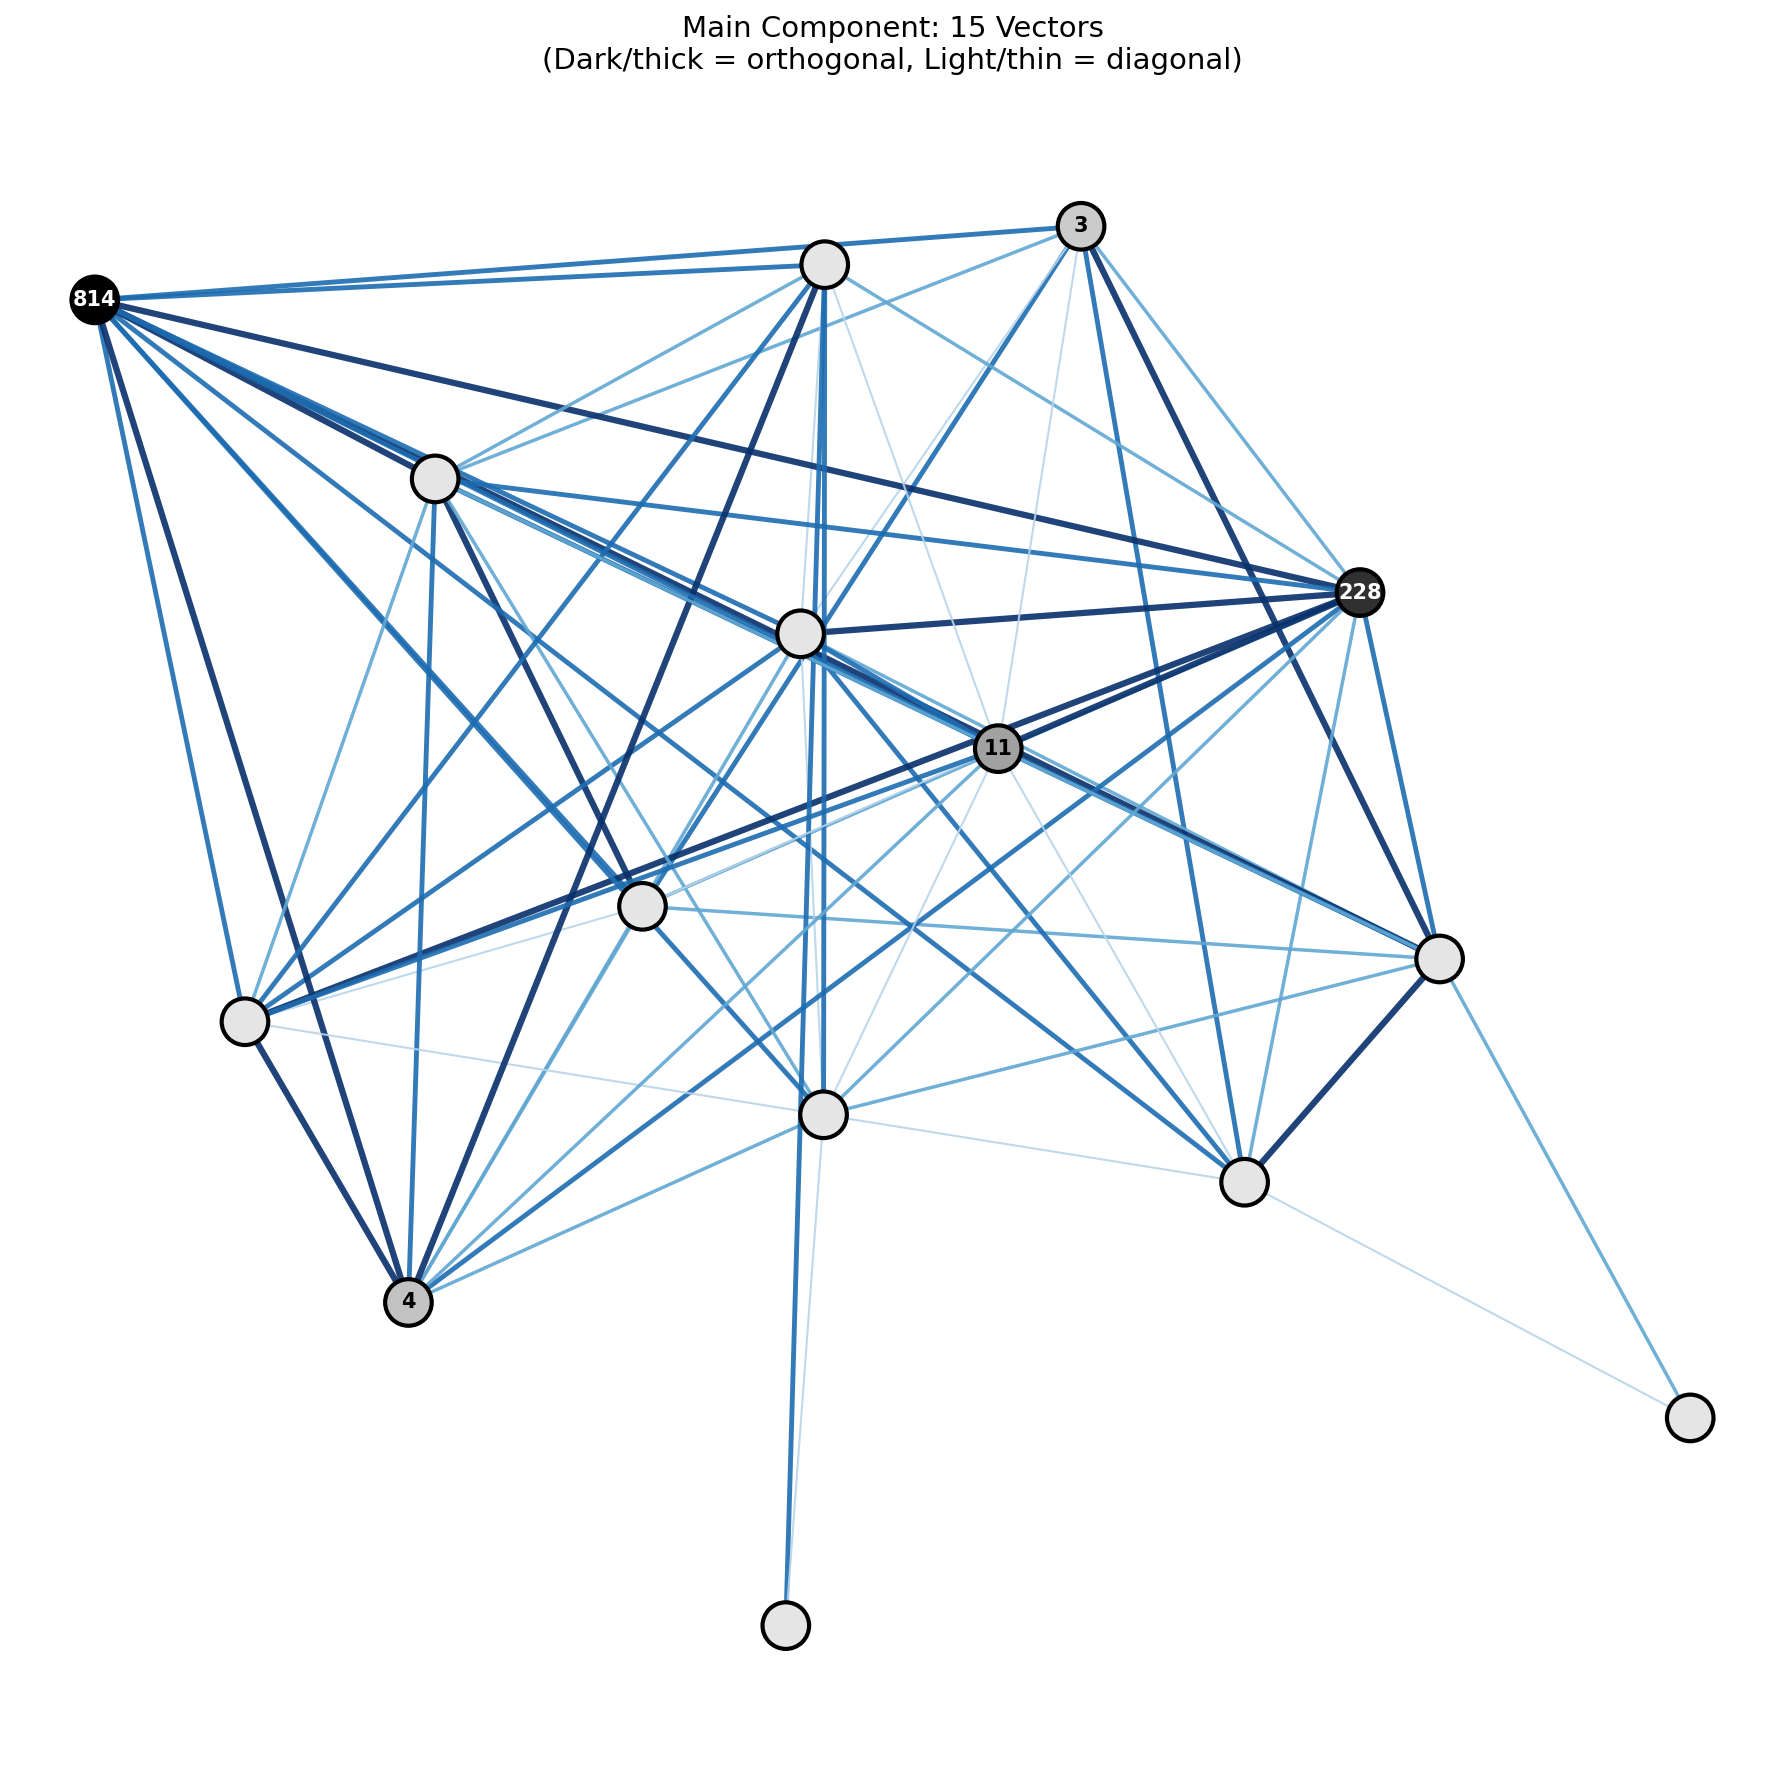

In [9]:
# Create weighted graph for layout (weight by 1/L1)
G_weighted = nx.Graph()
for node in main_nodes:
    G_weighted.add_node(node, count=counts[node].item())

main_edges = []
for i in main_nodes:
    for j in main_nodes:
        if i < j and linf_matrix[i, j].item() == 1:
            l1 = l1_matrix[i, j].item()
            G_weighted.add_edge(i, j, weight=1.0/l1, l1=l1)
            main_edges.append((i, j, l1))

# Layout
pos = nx.kamada_kawai_layout(G_weighted, weight='weight')

# Plot
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
ax.set_facecolor('#fafafa')

# Prepare node data
coords = np.array([pos[i] for i in main_nodes])
token_counts = np.array([counts[i].item() for i in main_nodes])
node_idx_map = {node: i for i, node in enumerate(main_nodes)}

log_counts = np.log10(token_counts + 1)
max_log = np.log10(815)
node_colors = 1 - (log_counts / max_log)

# Edge colors by L1
l1_min = min(e[2] for e in main_edges)
l1_max = max(e[2] for e in main_edges)

for i, j, l1 in main_edges:
    ii, jj = node_idx_map[i], node_idx_map[j]
    l1_norm = (l1 - l1_min) / (l1_max - l1_min) if l1_max > l1_min else 0
    color = plt.cm.Blues(1 - l1_norm * 0.7)
    linewidth = 3 - 2 * l1_norm
    ax.plot([coords[ii, 0], coords[jj, 0]], [coords[ii, 1], coords[jj, 1]],
            color=color, alpha=0.9, linewidth=linewidth, zorder=1)

# Nodes
ax.scatter(coords[:, 0], coords[:, 1], c=node_colors, cmap='gray', s=500,
           edgecolors='black', linewidths=2, vmin=0, vmax=1, zorder=2)

# Labels
for idx, node in enumerate(main_nodes):
    tc = token_counts[idx]
    label = str(tc) if tc > 1 else ''
    ax.annotate(label, (coords[idx, 0], coords[idx, 1]),
                fontsize=10, ha='center', va='center',
                color='white' if node_colors[idx] < 0.5 else 'black',
                fontweight='bold', zorder=3)

ax.set_title(f'Main Component: {len(main_nodes)} Vectors\n(Dark/thick = orthogonal, Light/thin = diagonal)',
             fontsize=14)
ax.axis('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/frozen_smoke_topology.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [10]:
print("=" * 60)
print("FROZEN SMOKE TOPOLOGY SUMMARY")
print("=" * 60)
print()
print(f"Total unique vectors: {n_unique}")
print(f"Total L∞=1 edges: {len(edge_data)}")
print(f"Connected components: {len(components)}")
print()
print(f"MAIN COMPONENT:")
print(f"  Vectors: {len(main_nodes)}")
print(f"  Tokens: {sum(counts[i].item() for i in main_nodes):,}")
print(f"  Black holes: {sum(1 for i in main_nodes if counts[i].item() > 1)}")
print(f"  Density: {nx.density(G_main):.1%}")
print()
print(f"BLACK HOLE CONNECTIVITY:")
print(f"  Adjacent pairs (L∞=1): {len(adjacent_pairs)}")
print(f"  Total possible pairs: {n_bh * (n_bh - 1) // 2}")
print()
print(f"L1 DISTRIBUTION (diagonality):")
for l1_val in sorted(set(l1_values)):
    count = l1_values.count(l1_val)
    print(f"  L1={l1_val}: {count} edges")

FROZEN SMOKE TOPOLOGY SUMMARY

Total unique vectors: 125
Total L∞=1 edges: 100
Connected components: 96

MAIN COMPONENT:
  Vectors: 15
  Tokens: 1,070
  Black holes: 5
  Density: 62.9%

BLACK HOLE CONNECTIVITY:
  Adjacent pairs (L∞=1): 10
  Total possible pairs: 78

L1 DISTRIBUTION (diagonality):
  L1=1: 24 edges
  L1=2: 37 edges
  L1=3: 24 edges
  L1=4: 13 edges
  L1=7: 2 edges
